In [5]:
import os
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

In [6]:
## uncomment for colab
## upload datasetGenerator.py prprocess dataset

# from google.colab import drive
# drive.mount('/content/drive')
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/BVP.zip"
# ! python /content/datasetGenerator.py

In [7]:
fraction_for_test = 0.15
num_class = 4
ALL_MOTION = [i for i in range(1, num_class+1)]
N_MOTION = len(ALL_MOTION) # Number of output classes
T_MAX = 38 # Number of timestamps
n_gru_hidden_units = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load dataset

In [8]:
# Load datasets
num_clients = 5
batch_size = 128
client_datasets = {}
client_loaders = {}

for i in range(1, num_clients + 1):
    # Load client data
    client_data = torch.load(f'./data/data{i}.pt')
    data = torch.from_numpy(client_data['data']).float()
    label = torch.from_numpy(client_data['label']).long()

    # Split data into training and testing sets
    data_train, data_test, label_train, label_test = train_test_split(
        data, label, test_size=fraction_for_test, random_state=12
    )

    train_dataset = TensorDataset(data_train, label_train)
    test_dataset = TensorDataset(data_test, label_test)
    client_datasets[f'client{i}'] = {'train': train_dataset, 'test':test_dataset}

    # Set up data loaders for each client's
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    client_loaders[f'client{i}'] = {'train': train_loader, 'test':test_loader}

# Model

In [9]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2, padding='same'),
            nn.ReLU(),
            nn.Flatten(),
            nn.BatchNorm1d(8 * 5 * 5),
            nn.Linear(8 * 5 * 5, 64),
            nn.ReLU(),

            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU()
        )

    def forward(self, x):
        return self.cnn(x)
    

class ConvGRUModel(nn.Module):
    def __init__(self, hidden_size, num_classes, num_timestamps):
        super(ConvGRUModel, self).__init__()
        
        # CNN module for each input timestamp
        self.cnn_modules = nn.ModuleList([
            CNNModule() for _ in range(num_timestamps)
        ])

        # GRU layers
        self.gru = nn.GRU(32, hidden_size, num_layers=num_timestamps, batch_first=True)

        # Fully connected layer at the output of last GRU
        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Relu activation for fully connected
        self.relu = nn.ReLU()

        # Softmax activation for classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(2)
        x = np.swapaxes(x, 0, 1)

        # Apply CNN module sequentially for each timestamp
        x = [module(xi) for module, xi in zip(self.cnn_modules, x)]

        x = torch.stack(x, dim=1)  # Stack along the time dimension

        # GRU layer
        x, _ = self.gru(x)

        # Apply ReLU activation after the GRU layer
        x = self.relu(x)
        # print(x.shape)

        # Fully connected layer at the output of last GRU
        x = self.fc_out(x[:, -1, :])

        # Softmax for classification
        x = self.softmax(x)

        return x

## Local training

In [10]:
class LocalTraining:
    def __init__(self, model, n_gru_hidden_units, num_class, timestamp, device, client_loaders):
        self.model = model
        self.n_gru_hidden_units = n_gru_hidden_units
        self.num_class = num_class
        self.timestamp = timestamp
        self.device = device
        self.client_loaders = client_loaders

    # train function
    def train(self, model, device, train_loader, optimizer, criterion):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            
            # target = onehot_encoding(target, 4).long().to(device)

            loss = criterion(output, target)
            # print(loss.item())
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
        
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        return train_loss, train_accuracy

    # test function
    def test(self, model, device, test_loader, criterion):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                _, predicted = output.max(1)
                correct += predicted.eq(target).sum().item()

        test_loss /= len(test_loader)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

    def run(self, num_epochs):
        result = []
        for user in range(1, num_clients+1):
            print(f'- Client {user} training :')
            model = self.model(self.n_gru_hidden_units, self.num_class, self.timestamp).to(self.device)
            optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
            criterion = nn.CrossEntropyLoss()
            # scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

            client_results = {'loss':[], 'accuracy':[]}
            for epoch in range(num_epochs):

                train_loss, train_accuracy = self.train(model, self.device, self.client_loaders[f'client{user}']['train'], optimizer, criterion)
                val_loss, val_accuracy = self.test(model, self.device, self.client_loaders[f'client{user}']['test'], criterion)

                loss = (train_loss, val_loss)
                accuracy = (train_accuracy, val_accuracy)
                print(f'        Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,', 
                        f' Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
                    
                client_results['loss'].append(loss)
                client_results['accuracy'].append(accuracy)
                
                # scheduler.step()
            
            result.append(client_results)
            # torch.save(model.state_dict(), f'./model/client{user}_model.pth')

        return result

In [11]:
local_training = LocalTraining(model=ConvGRUModel,
                               n_gru_hidden_units=4, 
                               num_class=N_MOTION, 
                               timestamp=T_MAX, 
                               device=device, 
                               client_loaders=client_loaders
                               )
local_training_result = local_training.run(num_epochs=15)

- Client 1 training :
        Epoch: 1, Train Loss: 1.3851, Train Accuracy: 26.64%,  Val Loss: 1.3898, Val Accuracy: 24.01%
        Epoch: 2, Train Loss: 1.3853, Train Accuracy: 26.64%,  Val Loss: 1.3922, Val Accuracy: 24.01%
        Epoch: 3, Train Loss: 1.3850, Train Accuracy: 26.64%,  Val Loss: 1.3896, Val Accuracy: 24.01%
        Epoch: 4, Train Loss: 1.3852, Train Accuracy: 26.64%,  Val Loss: 1.3883, Val Accuracy: 24.01%
        Epoch: 5, Train Loss: 1.3844, Train Accuracy: 26.64%,  Val Loss: 1.3909, Val Accuracy: 24.01%
        Epoch: 6, Train Loss: 1.3846, Train Accuracy: 26.64%,  Val Loss: 1.3872, Val Accuracy: 24.01%
        Epoch: 7, Train Loss: 1.3849, Train Accuracy: 26.64%,  Val Loss: 1.3853, Val Accuracy: 24.01%
        Epoch: 8, Train Loss: 1.3852, Train Accuracy: 26.64%,  Val Loss: 1.3890, Val Accuracy: 24.01%
        Epoch: 9, Train Loss: 1.3848, Train Accuracy: 26.64%,  Val Loss: 1.3857, Val Accuracy: 24.01%
        Epoch: 10, Train Loss: 1.3846, Train Accuracy: 26.64

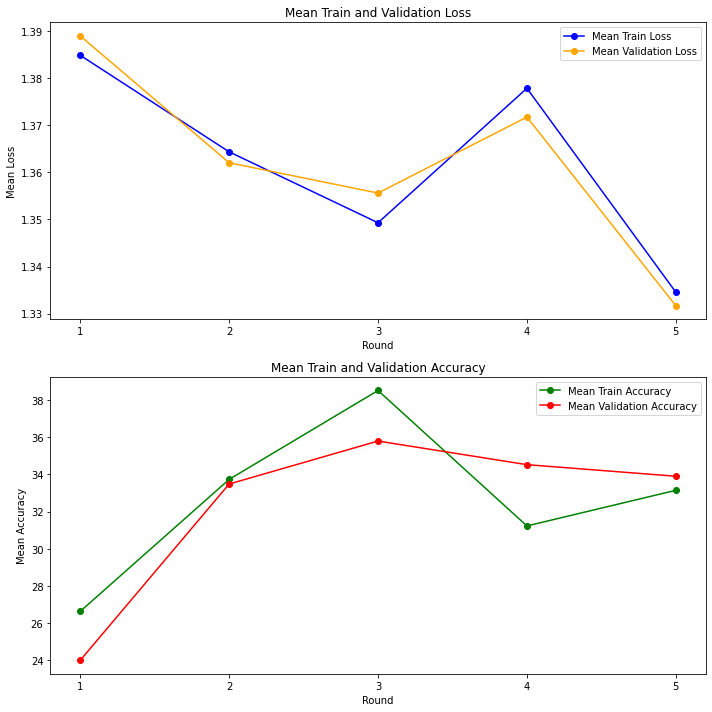

In [12]:
from utils import *
plot_result(local_training_result)

## Centralize training

In [13]:
# Load datasets
num_clients = 5
batch_size = 128
client_loaders_all = {}

train_all = {'data':[], 'label':[]}
test_all = {'data':[], 'label':[]}

for i in range(1, num_clients + 1):
    # Load client data
    client_data = torch.load(f'./data/data{i}.pt')
    data = torch.from_numpy(client_data['data']).float()
    label = torch.from_numpy(client_data['label']).long()

    # Split data into training and testing sets
    data_train, data_test, label_train, label_test = train_test_split(
        data, label, test_size=fraction_for_test, random_state=12
    )

    train_all['data'].append(data_train)
    train_all['label'].append(label_train)
    test_all['data'].append(data_test)
    test_all['label'].append(label_test)

train_dataset_all = TensorDataset(torch.cat(train_all['data']), torch.cat(train_all['label']))
test_dataset_all = TensorDataset(torch.cat(test_all['data']), torch.cat(test_all['label']))

# Set up data loaders for each client's
train_loader_all = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=True)
test_loader_all = DataLoader(test_dataset_all, batch_size=batch_size, shuffle=True)

client_loaders_all[f'client{1}'] = {'train': train_loader_all, 'test':test_loader_all}

In [14]:
local_training = LocalTraining(model=ConvGRUModel,
                               n_gru_hidden_units=n_gru_hidden_units, 
                               num_class=N_MOTION, 
                               timestamp=T_MAX, 
                               device=device, 
                               client_loaders=client_loaders_all
                               )

training_result = local_training.run(num_epochs=15)

- Client 1 training :
        Epoch: 1, Train Loss: 1.3563, Train Accuracy: 31.85%,  Val Loss: 1.3567, Val Accuracy: 27.50%
        Epoch: 2, Train Loss: 1.3536, Train Accuracy: 31.58%,  Val Loss: 1.3520, Val Accuracy: 32.69%
        Epoch: 3, Train Loss: 1.3534, Train Accuracy: 32.10%,  Val Loss: 1.3534, Val Accuracy: 32.69%
        Epoch: 4, Train Loss: 1.3532, Train Accuracy: 32.10%,  Val Loss: 1.3515, Val Accuracy: 32.69%
        Epoch: 5, Train Loss: 1.3533, Train Accuracy: 32.10%,  Val Loss: 1.3523, Val Accuracy: 32.69%
        Epoch: 6, Train Loss: 1.3532, Train Accuracy: 32.10%,  Val Loss: 1.3514, Val Accuracy: 32.69%
        Epoch: 7, Train Loss: 1.3530, Train Accuracy: 32.10%,  Val Loss: 1.3514, Val Accuracy: 32.69%
        Epoch: 8, Train Loss: 1.3530, Train Accuracy: 32.10%,  Val Loss: 1.3517, Val Accuracy: 32.69%
        Epoch: 9, Train Loss: 1.3535, Train Accuracy: 32.10%,  Val Loss: 1.3516, Val Accuracy: 32.69%
        Epoch: 10, Train Loss: 1.3531, Train Accuracy: 32.10

KeyError: 'client2'